In [1]:
import torch
from torch.nn import *
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torchvision.models import wide_resnet50_2, mobilenet_v2
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
import pandas as pd
import math
from sklearn.metrics import ConfusionMatrixDisplay as CMD
from sklearn.metrics import confusion_matrix as CMT
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, f1_score, jaccard_score

In [2]:
%%capture
!pip install pkbar
import pkbar
!pip install torchviz
from torchviz import make_dot
! pip install --upgrade albumentations
import  albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import pkbar

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path='/content/drive/MyDrive/RFMiD Dataset'
if os.getcwd() is not path:
  os.chdir(path)

from dataset import *
from utils import *

In [5]:
batch_size= 16
device = "cuda" if torch.cuda.is_available() else "cpu"
input_shape=(3,512,512)
learning_rate=3e-4
num_epochs= 100

In [6]:
train_dir= 'data/Training Set'
val_dir= 'data/Validation Set'
test_dir= 'data/Testing Set'

train_csv_path= 'data/a. RFMiD_Training_Labels.csv'
val_csv_path= 'data/b. RFMiD_Validation_Labels.csv'
test_csv_path= 'data/c. RFMiD_Testing_Labels.csv'
check_pt_file= 'weights/wide_resnet50_2.pth.tar'
print(check_pt_file)

weights/wide_resnet50_2.pth.tar


In [7]:
transforms = A.Compose(
    [A.HorizontalFlip(p=0.5),
     A.RandomRotate90(p=0.5), 
     A.CLAHE(p=1),
     A.RandomBrightnessContrast(p=0.8),
     A.RandomGamma(p=0.8),
     ToTensorV2()]
)

In [8]:
train_dataset= RFMiD_Dataset(train_dir, train_csv_path, input_shape, transforms)
val_dataset= RFMiD_Dataset(val_dir, val_csv_path, input_shape, transforms)
test_dataset= RFMiD_Dataset(test_dir, test_csv_path, input_shape, transforms)

train_loader= DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader= DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader= DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

print("Weights for each class: ")
print(f"Training Dataset: {train_dataset.get_class_weights()}")
print(f"Validation Dataset: {val_dataset.get_class_weights()}")
print(f"Test Dataset: {test_dataset.get_class_weights()}")

num_classes= len(train_dataset.get_class_weights())
print(f"Number of classes: {num_classes}")

Weights for each class: 
Training Dataset: {0: 0.1958333333333333, 1: 0.8041666666666667}
Validation Dataset: {0: 0.20625000000000004, 1: 0.79375}
Test Dataset: {0: 0.19374999999999998, 1: 0.80625}
Number of classes: 2


In [9]:
# def get_dataloaders():

#   train_dir= 'data/Training Set'
#   val_dir= 'data/Validation Set'
#   test_dir= 'data/Testing Set'

#   train_csv_path= 'data/a. RFMiD_Training_Labels.csv'
#   val_csv_path= 'data/b. RFMiD_Validation_Labels.csv'
#   test_csv_path= 'data/c. RFMiD_Testing_Labels.csv'
#   check_pt_file= 'weights/wide_resnet50_2.pth.tar'
#   transforms = A.Compose(
#       [A.HorizontalFlip(p=0.5),
#         A.RandomRotate90(p=0.5), 
#         A.CLAHE(p=1),
#         A.RandomBrightnessContrast(p=0.8),
#         A.RandomGamma(p=0.8),
#         ToTensorV2()]

#   train_dataset= RFMiD_Dataset(train_dir, train_csv_path, input_shape, transforms)
#   val_dataset= RFMiD_Dataset(val_dir, val_csv_path, input_shape, transforms=ToTensorV2())
#   test_dataset= RFMiD_Dataset(test_dir, test_csv_path, input_shape, transforms=ToTensorV2())

#   train_loader= DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
#   val_loader= DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
#   test_loader= DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

#   return train_loader, val_loader, test_loader

### Plotting the images with classes



In [10]:
# plotter(train_loader, figsize=(30, 20))

#### Comparision Between Separable Convolutions and Straight Forward Convolution

In [11]:
model= wide_resnet50_2(progress=True).to(device=device)
model.fc= Sequential(Linear(model.fc.in_features, num_classes),
                     Softmax(dim=1)).to(device=device)

summary(model, input_size= input_shape, batch_size=batch_size, device=device)
training_LOSS= CrossEntropyLoss(weight= torch.Tensor(list(train_dataset.get_class_weights().values())).to(device=device))
validation_LOSS= CrossEntropyLoss(weight=torch.Tensor(list(val_dataset.get_class_weights().values())).to(device=device))
optimizer= Adam(model.parameters(), lr=learning_rate)
scheduler= StepLR(optimizer, step_size=5, gamma=0.8)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 256, 256]           9,408
       BatchNorm2d-2         [16, 64, 256, 256]             128
              ReLU-3         [16, 64, 256, 256]               0
         MaxPool2d-4         [16, 64, 128, 128]               0
            Conv2d-5        [16, 128, 128, 128]           8,192
       BatchNorm2d-6        [16, 128, 128, 128]             256
              ReLU-7        [16, 128, 128, 128]               0
            Conv2d-8        [16, 128, 128, 128]         147,456
       BatchNorm2d-9        [16, 128, 128, 128]             256
             ReLU-10        [16, 128, 128, 128]               0
           Conv2d-11        [16, 256, 128, 128]          32,768
      BatchNorm2d-12        [16, 256, 128, 128]             512
           Conv2d-13        [16, 256, 128, 128]          16,384
      BatchNorm2d-14        [16, 256, 1

In [12]:
# x= torch.randn((batch_size,3,512,512)).to(device=device)
# scores= model(x)
# loss= training_LOSS(scores, labels.to(device=device))
# loss.backward()
# grads= model.get_activations_gradient()

In [13]:
def gradcam(img, model, class_label=1):

  model.eval()
  img= (img-img.min())/(img.max()-img.min())
  preds = model([img]).argmax(dim=1)
  preds[:,class_label].backward()
  gradients= model.get_activations_gradient()
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
  activations = model.get_activations([img]).detach()
  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]
  heatmap = torch.mean(activations, dim=1).squeeze()
  heatmap /= torch.max(heatmap)
  return heatmap

In [14]:
def check_accuracy(scores, targets):

  num_correct=0
  num_samples=0
  _, predictions= scores.max(1)
  num_correct+= (predictions== targets).sum()
  num_samples= predictions.size(0)

  return num_correct/num_samples

In [15]:
def save_checkpoint(model, optimizer, file_name):

  checkpoint= {'state_dict': model.state_dict(),
             'optimizer_dict': optimizer.state_dict()}
  torch.save(checkpoint,file_name)

def load_checkpoint(model, optimizer, file_name):
  check_pt= torch.load(file_name, map_location= torch.device(device))
  model.load_state_dict(check_pt['state_dict'])
  optimizer.load_state_dict(check_pt['optimizer_dict'])

  return model, optimizer

In [16]:
# model, optimizer= load_checkpoint(model, optimizer, check_pt_file)

In [17]:
# train_per_epoch = len(train_loader)
# val_per_epoch = len(val_loader)
# min_loss = math.inf
# # max_acc= 0

# for epoch in range(num_epochs):
#   train_losses = []
#   train_accs = []
#   kbar_train = pkbar.Kbar(target = train_per_epoch, epoch = epoch, num_epochs = num_epochs)
#   model.train()
#   for batch_idx, (data, targets) in enumerate(train_loader):

#     data = data.to(device=device)
#     targets = targets.to(device=device)

#     scores = model(data)
#     train_loss = training_LOSS(scores, targets)
#     train_losses.append(train_loss.item())
    
#     optimizer.zero_grad()
#     train_loss.backward()
#     optimizer.step()

#     train_acc = check_accuracy(scores, targets)
#     train_accs.append(train_acc.item())
#     kbar_train.update(batch_idx, values=[("loss", train_loss.item()), ("accuracy", train_acc.item())])
  
#   mean_train_loss = np.mean(train_losses)
#   mean_train_acc = np.mean(train_accs)
#   kbar_train.update(train_per_epoch, values=[("loss", mean_train_loss), ("accuracy", mean_train_acc)])#For each epoch

#   val_losses = []
#   val_accs = []
#   kbar_val = pkbar.Kbar(target = val_per_epoch, epoch = epoch, num_epochs = num_epochs)
#   with torch.no_grad():
#     model.eval()
#     for batch_idx, (data, targets) in enumerate(val_loader):
#       data = data.to(device=device)
#       targets = targets.to(device=device)

#       scores = model(data)
#       val_loss = validation_LOSS(scores, targets)
#       val_losses.append(val_loss.item())

#       val_acc = check_accuracy(scores, targets)
#       val_accs.append(val_acc.item())
#       kbar_val.update(batch_idx, values=[("val_loss", val_loss.item()), ("val_accuracy", val_acc.item())])
    
#     mean_val_loss = np.mean(val_losses)
#     mean_val_acc = np.mean(val_accs)
#     kbar_val.update(val_per_epoch, values=[("val_loss", mean_val_loss), ("val_accuracy", mean_val_acc)])#For each epoch
    
#     if mean_val_loss < min_loss:
#       min_loss = mean_val_loss
#       print('\nImproved validation Loss: {}'.format(min_loss))
#       save_checkpoint(model, optimizer, check_pt_file)
#       print('Model saved to {}\n'.format(check_pt_file))
      

In [18]:
model, _= load_checkpoint(model, optimizer, check_pt_file)

In [19]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([], device=device)
    all_labels= torch.tensor([], device=device)
    model.eval()
    for images,labels in loader:
        images= images.to(device)
        labels= labels.to(device)
        scores = model(images)
        _, preds= scores.max(1)
        all_preds = torch.cat((all_preds, preds),dim=0)
        all_labels = torch.cat((all_labels, labels),dim=0)
    return all_preds, all_labels

with torch.no_grad():
    all_preds, all_labels = get_all_preds(model.to(device), test_loader)


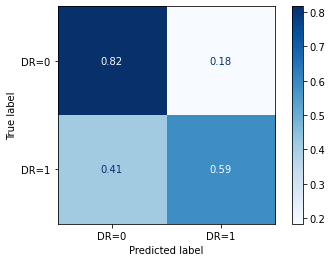

[0.89194915 0.43452381]
[0.81589147 0.58870968]
[0.74250441 0.33333333]
[0.85222672 0.5       ]
0.771875


In [20]:
cmt= CMT(all_labels.cpu(), all_preds.cpu())
prec, rec, f1,_= precision_recall_fscore_support(all_labels.cpu(), all_preds.cpu())
j_score= jaccard_score(all_labels.cpu(), all_preds.cpu(), average=None)
acc= accuracy_score(all_labels.cpu(), all_preds.cpu())
names= ['DR=0', 'DR=1']
cmt = cmt.astype('float') / cmt.sum(axis=1)[:, np.newaxis]
disp = CMD(confusion_matrix=cmt, display_labels=['DR=0', 'DR=1'])
disp.plot(cmap='Blues')
plt.show()


print(prec)
print(rec)
print(j_score)
print(f1)
print(acc)

In [21]:
mean_f1= f1_score(all_labels.cpu(), all_preds.cpu(), average='weighted')
avg_j_score= jaccard_score(all_labels.cpu(), all_preds.cpu(), average='weighted')
avg_prec, avg_rec, _, _=precision_recall_fscore_support(all_labels.cpu(), all_preds.cpu(), average='weighted')

print(avg_prec)                                         
print(avg_rec)
print(mean_f1)
print(avg_j_score)

0.8033229923325262
0.771875
0.7839827935222672
0.6632275132275132
